In [5]:
# Set up helper functions
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

def bag_loader(path, map_and_append_msg, topic_name = 'robot_state', normalize = ''):
    bag = rosbag.Bag(path)
    num_obs = bag.get_message_count(topic_name)
    if num_obs is 0:
        topic_name = '/'+topic_name
        num_obs = bag.get_message_count(topic_name)
    print('Loading ros bag {}  with {} msgs on topic {}'.format(path, num_obs, topic_name))

    msgs = {}
    t = []
    for _, msg, t_ros in bag.read_messages(topics=[topic_name]):
        t.append(t_ros.to_sec())
        map_and_append_msg(msg, msgs)
    t = [tt-t[0] for tt in t]

    msgs_in_order = {}
    for key in msgs.keys():
        t_in_order, el_in_order = zip(*sorted(zip(t,msgs[key])))
        msgs_in_order[key] = np.array(el_in_order).T
    msgs_in_order['t'] = t_in_order
    
    if normalize is not '':
        msgs_in_order[normalize] = (msgs_in_order[normalize].T-msgs_in_order[normlize][:,0]).T
        
    return msgs_in_order

def get_aligned_msgs(msgs1, msgs2):
    ''' 
    Select entries from msgs2 which occured most recently before msgs1
    '''
    aligned_msgs2 = {key:[] for key in msgs2.keys()}
    t2 = np.array(msgs2['t'])
    for t1 in msgs1['t']:
        last_before_t1 = np.where(t2<=t1)[0][-1] # find last time in t which is 
        for key in msgs2.keys():
            if key == 't': continue
            aligned_msgs2[key].append(msgs2[key][:,last_before_t1])

    for key in msgs2.keys():
        aligned_msgs2[key] = np.array(aligned_msgs2[key]).T
    
    return aligned_msgs2

def map_robot_state(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('pos', 'vel', 'force'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['force'].append(msg.effort)
    return prev_msgs
    
def map_impedance_gains(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('K', 'B', 'M', 'Fd'):
            prev_msgs[el] = []
    prev_msgs['K'].append(msg.position)
    prev_msgs['B'].append(msg.velocity)
    prev_msgs['M'].append(msg.effort[:len(msg.position)])
    prev_msgs['Fd'].append(msg.effort[len(msg.position):])

def map_delta_impedance_gains(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('dK', 'dB', 'dM', 'Fd'):
            prev_msgs[el] = []
    prev_msgs['dK'].append(msg.position)
    prev_msgs['dB'].append(msg.velocity)
    prev_msgs['dM'].append(msg.effort[:len(msg.position)])
    prev_msgs['Fd'].append(msg.effort[len(msg.position):])
    
def plot_model_cov(model_path, ext = 0.05):
    import pickle
    from gp_mpc.gp_wrapper import gp_model
    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    
    with open(model_path, 'rb') as f:
        models = pickle.load(f)
        modes = list(models.keys())
        print('Loaded models for {}'.format(modes))

    state_bounds = [np.full(3,1e10), np.full(3,-1e10)]
    for mode in modes:
        current_range = models[mode].get_xrange()
        state_bounds = [np.minimum(state_bounds[0],current_range[0]),
                        np.maximum(state_bounds[1],current_range[1])]

    fig2 = plt.figure(dpi=200)
    ax2 = fig2.gca(projection='3d')
    max_force = np.zeros((3,1))
    min_cov = np.full((3,1), 1e10)
    max_cov = np.zeros((3,1))
    exp = ext
    off = 0
    x, y, z = np.meshgrid(np.linspace(state_bounds[0][0+off]-exp, state_bounds[1][0+off]+exp, 5),
                          np.linspace(state_bounds[0][1+off]-exp, state_bounds[1][1+off]+exp, 5),
                          np.linspace(state_bounds[0][2+off]-exp, state_bounds[1][2+off]+exp, 5))
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    offset = 0.0
    colors = ['r','g','b']
    for mode in modes:
        means = []
        covs   = []
        c = colors.pop()
        test_pt = models[mode].get_mean_state()
        for xi, yi, zi in zip(x,y,z):
            test_pt[off:off+3] = np.array([xi,yi,zi])
            mu, cov = models[mode].predict(test_pt)
            covs.append(0.5*np.min(np.diag(cov)))
        ax2.scatter(x+offset, y+offset, z+offset, s=covs, color = c)
        offset += 0.02
    # print(covs)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    #ax2.set_title('GP for {}'.format(mode))
    return fig2, ax2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [11]:
# Plotting rail assembly over position
# Jupyter notebook should be started in root folder to do imports

%matplotlib

# Define the path to the bags wanted to plot 
baggies = [ '../data/validation/rail/1.bag', '../data/validation/rail/2.bag', 
            '../data/rail/rail_validation_1.bag', '../data/rail/rail_validation_2.bag']# '../data/validation/rail/3.bag']
gp_model_path = '../data/rail/GP_models.pkl'
scale_B = 0.00002
scale_M = 0.0015

#fig, ax = plot_model_cov(gp_model_path)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")

fig.suptitle("Rail assembly with GP-MPC")

for bag in baggies:

    
    imp_msgs = bag_loader(bag, map_impedance_gains, topic_name = 'impedance_gains')
    state_msgs = bag_loader(bag, map_robot_state, topic_name = 'robot_state')

    state_msgs_aligned = get_aligned_msgs(imp_msgs, state_msgs)

    p = state_msgs_aligned['pos']
    B = imp_msgs['B']
    M = imp_msgs['M']
    subsample_rate = 150
    skipcnt = 0
    for p, B, M  in zip(state_msgs_aligned['pos'].T, imp_msgs['B'].T, imp_msgs['M'].T):
        if skipcnt > subsample_rate:
            skipcnt = 0
        else:
            skipcnt += 1
            continue

        line_damp = ax.plot([p[0]-scale_B*B[1], p[0]+scale_B*B[1]],
                [p[1], p[1]],
                [p[2], p[2]],'r', label = 'Damping')[0]
        ax.plot([p[0], p[0]],
                [p[1]-scale_B*B[0], p[1]+scale_B*B[0]],
                [p[2], p[2]],'r')
        ax.plot([p[0], p[0]],
                [p[1], p[1]],
                [p[2]-scale_B*B[2], p[2]+scale_B*B[2]],'r')
        p = p + 0.0009*np.ones(6)
        line_mass = ax.plot([p[0]-scale_M*M[1], p[0]+scale_M*M[1]],
                [p[1], p[1]],
                [p[2], p[2]],'b', label = 'Mass')[0]
        ax.plot([p[0], p[0]],
                [p[1]-scale_M*M[0], p[1]+scale_M*M[0]],
                [p[2], p[2]],'b')
        ax.plot([p[0], p[0]],
                [p[1], p[1]],
                [p[2]-scale_M*M[2], p[2]+scale_M*M[2]],'b')
plt.tight_layout()
plt.subplots_adjust(left=-0.11, right=1.11, bottom=0.0, top=1)
plt.legend(handles=[line_damp, line_mass],labels=['Damping', 'Mass'])
plt.show()

Using matplotlib backend: GTK3Agg


Loading ros bag ../data/contact_var/validate/no_var_no_chance_no_well_damped.bag  with 855 msgs on topic /robot_state
Loading ros bag ../data/contact_var/validate/no_var_no_chance_no_well_damped.bag  with 112 msgs on topic /impedance_gains_sim
Loading ros bag ../data/contact_var/validate/no_var_no_chance_no_well_damped.bag  with 112 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var/validate/no_var_chance_no_well_damped.bag  with 864 msgs on topic /robot_state
Loading ros bag ../data/contact_var/validate/no_var_chance_no_well_damped.bag  with 182 msgs on topic /impedance_gains_sim
Loading ros bag ../data/contact_var/validate/no_var_chance_no_well_damped.bag  with 179 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var/validate/var_chance_no_well_damped.bag  with 875 msgs on topic /robot_state
Loading ros bag ../data/contact_var/validate/var_chance_no_well_damped.bag  with 122 msgs on topic /impedance_gains_sim
Loading ros bag ../data/contact_v

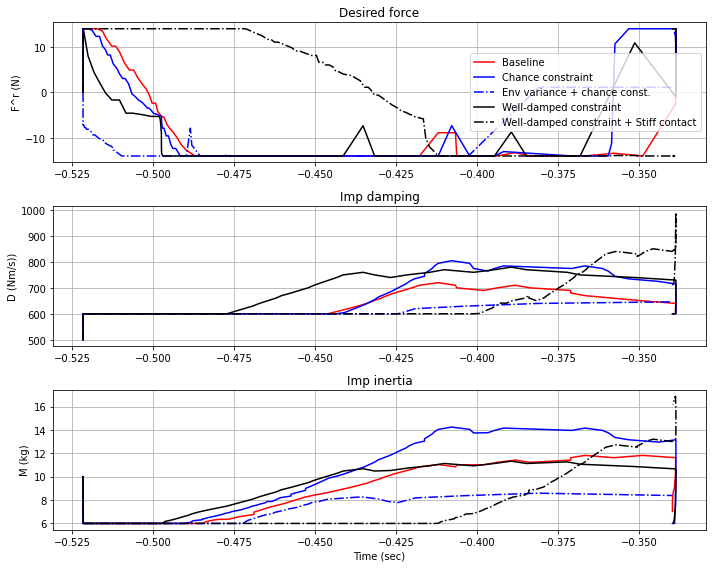

In [41]:
### Comparing with and without variance in contact
# %matplotlib
path = '../data/contact_var/validate/'
baggies = [ 'no_var_no_chance_no_well_damped.bag',
            'no_var_chance_no_well_damped.bag',
            'var_chance_no_well_damped.bag',
            'no_var_no_chance_well_damped.bag',
            'stiff_no_chance_well_damped.bag',
          ]  
namies = [ 'Baseline',
           'Chance constraint',
           'Env variance + chance const.',
           'Well-damped constraint',
           'Well-damped constraint + Stiff contact'
         ]
fig, axs = plt.subplots(3, figsize=(10,8))
#fig.suptitle("Contact with GP-MPC")
cols = ['r', 'b', 'b-.', 'k', 'k-.']
for bag, name in zip(baggies, namies):
    col = cols.pop(0)
    state_msgs = bag_loader(path+bag, map_robot_state, topic_name = 'robot_state')
    imp_msgs = bag_loader(path+bag, map_impedance_gains, topic_name = 'impedance_gains_sim')
    delta_imp_msgs = bag_loader(path+bag, map_delta_impedance_gains, topic_name = 'delta_impedance_gains')
    state_msgs = get_aligned_msgs(imp_msgs, state_msgs)
    delta_imp_msgs = get_aligned_msgs(imp_msgs, delta_imp_msgs)

    ind = 2
    #plt.figure(figsize=(6,3), dpi= 100)
    
    axs[0].plot(-state_msgs['pos'][2,:], delta_imp_msgs['Fd'][ind], col, label = name)
    #axs[0].plot(imp_msgs['t'], delta_imp_msgs['Fd'][ind], col, label = name)
    axs[1].plot(-state_msgs['pos'][2,:], imp_msgs['B'][ind], col)
    axs[2].plot(-state_msgs['pos'][2,:], imp_msgs['M'][ind], col)

axs[0].legend()
for i in range(3): axs[i].grid(True)
#for i in range(3): axs[i].set_xlim([-0.525,-0.343])
plt.xlabel('Time (sec)')
axs[0].set(ylabel='F^r (N)', title = 'Desired force')
axs[1].set(ylabel='D (Nm/s))', title = 'Imp damping')
axs[2].set(ylabel='M (kg)', title = 'Imp inertia')
plt.tight_layout()
plt.show()


Loading ros bag rail_valid_3_4.bag  with 719 msgs on topic /delta_impedance_gains


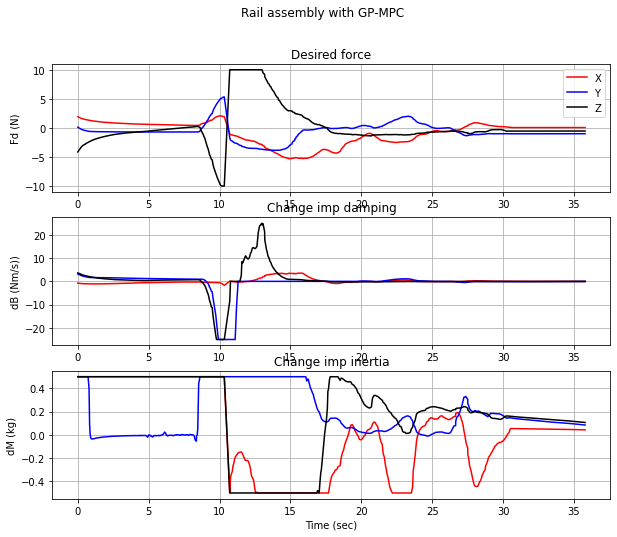

In [46]:
# Plotting rail assembly over time
# %matplotlib

bag = 'rail_valid_3_4.bag'

fig, axs = plt.subplots(3, figsize=(10,8))
fig.suptitle("Rail assembly with GP-MPC")
cols = ['r', 'b', 'k', 'r:', 'b:', 'k:']
msgs = bag_loader(bag, map_delta_impedance_gains, topic_name = 'delta_impedance_gains')
dM = msgs['dM']
Fd = msgs['Fd']
dB = msgs['dB']
t = msgs['t']


dirs = ['X', 'Y', 'Z']
for ind in range(3):
    col = cols.pop(0)
#plt.figure(figsize=(6,3), dpi= 100)
    axs[0].plot(t, Fd[ind], col, label = dirs.pop(0))
    axs[1].plot(t, dB[ind], col)
    axs[2].plot(t, dM[ind], col)

axs[0].legend()
for i in range(3): axs[i].grid(True)
#for i in range(3): axs[i].set_xlim([0,6])
plt.xlabel('Time (sec)')
axs[0].set(ylabel='Fd (N)', title = 'Desired force')
axs[1].set(ylabel='dB (Nm/s))', title = 'Change imp damping')
axs[2].set(ylabel='dM (kg)', title = 'Change imp inertia')

plt.show()


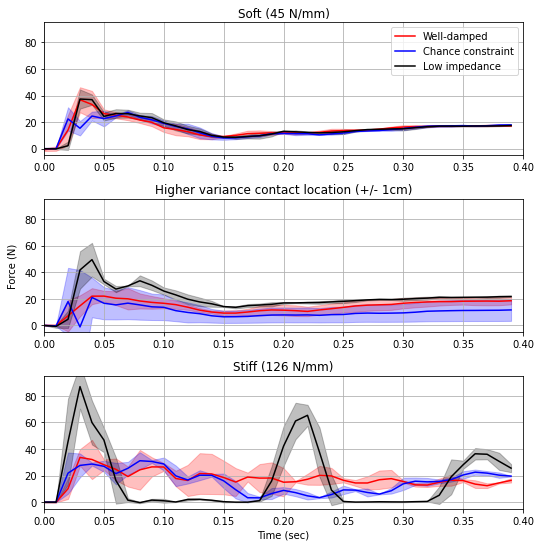

In [5]:
### Contact variance/stiffness

path = '../data/contact_var2/valid_18_07/'
list_of_baggies = [[ 'soft_wd_', 'soft_cc_', 'soft_low_'],
           [ 'var_wd_cc_', 'var_low_', 'var_wd_'],  
           [  'hard_cc_', 'hard_wd_', 'hard_low_']]
datasets = ['Soft (45 N/mm)', 'Higher variance contact location (+/- 1cm)', 'Stiff (126 N/mm)']
namies = [ 'Well-damped', 'Chance constraint', 'Low impedance']

fig, axs = plt.subplots(3, figsize=(8,8))
#fig.suptitle("Contact with GP-MPC")
for subplot_idx, (baggies, dataset) in enumerate(zip(list_of_baggies, datasets)):
    cols = ['r', 'b', 'k' ]
    for bag, name in zip(baggies, namies):
        col = cols.pop(0)
        forces = []
        damps = []
        imps = []
        for i in range(1,4):
            state_msgs_orig = bag_loader(path+bag+str(i)+'.bag', map_robot_state, topic_name = 'robot_state')
            imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_impedance_gains, topic_name = 'impedance_gains')
            delta_imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_delta_impedance_gains, topic_name = 'delta_impedance_gains')
            state_msgs = get_aligned_msgs(imp_msgs, state_msgs_orig)
            delta_imp_msgs = get_aligned_msgs(imp_msgs, delta_imp_msgs)

            ind = 2
            start_ind = np.argmax(np.abs(state_msgs['force'][2,:])>5)-3
            #print("{} has st ind {}".format(bag+str(i), start_ind))
            plot_range = 40
            forces.append(np.array(state_msgs_orig['force'][ind,start_ind:start_ind+plot_range]))
            #axs[0].plot(-state_msgs['pos'][2,:], imp_msgs['Fd'][ind], col, label = name)
        mean = np.mean(forces, axis = 0)
        var = np.sqrt(np.var(forces, axis = 0))
        times = [x / 100.0 for x in range(0, plot_range)]
        axs[subplot_idx].plot(times, mean, col, label = name)
        axs[subplot_idx].fill_between(times, (mean-var), (mean+var), color=col, alpha=.25)
        axs[subplot_idx].set_title(dataset)
        
axs[0].legend()
for i in range(3): axs[i].grid(True)
for i in range(3): axs[i].set_xlim([0.0, 0.4])
for i in range(3): axs[i].set_ylim([-5, 95])
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time (sec)')
plt.ylabel('Force (N)')
plt.tight_layout()
plt.show()

Loading ros bag ../data/contact_var2/valid_18_07/var_wd_cc_1.bag  with 2115 msgs on topic /robot_state
Loading ros bag ../data/contact_var2/valid_18_07/var_wd_cc_1.bag  with 2116 msgs on topic /impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/var_wd_cc_1.bag  with 258 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/var_low_1.bag  with 1217 msgs on topic /robot_state
Loading ros bag ../data/contact_var2/valid_18_07/var_low_1.bag  with 1218 msgs on topic /impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/var_low_1.bag  with 488 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/var_wd_1.bag  with 1570 msgs on topic /robot_state
Loading ros bag ../data/contact_var2/valid_18_07/var_wd_1.bag  with 1583 msgs on topic /impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/var_wd_1.bag  with 221 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/

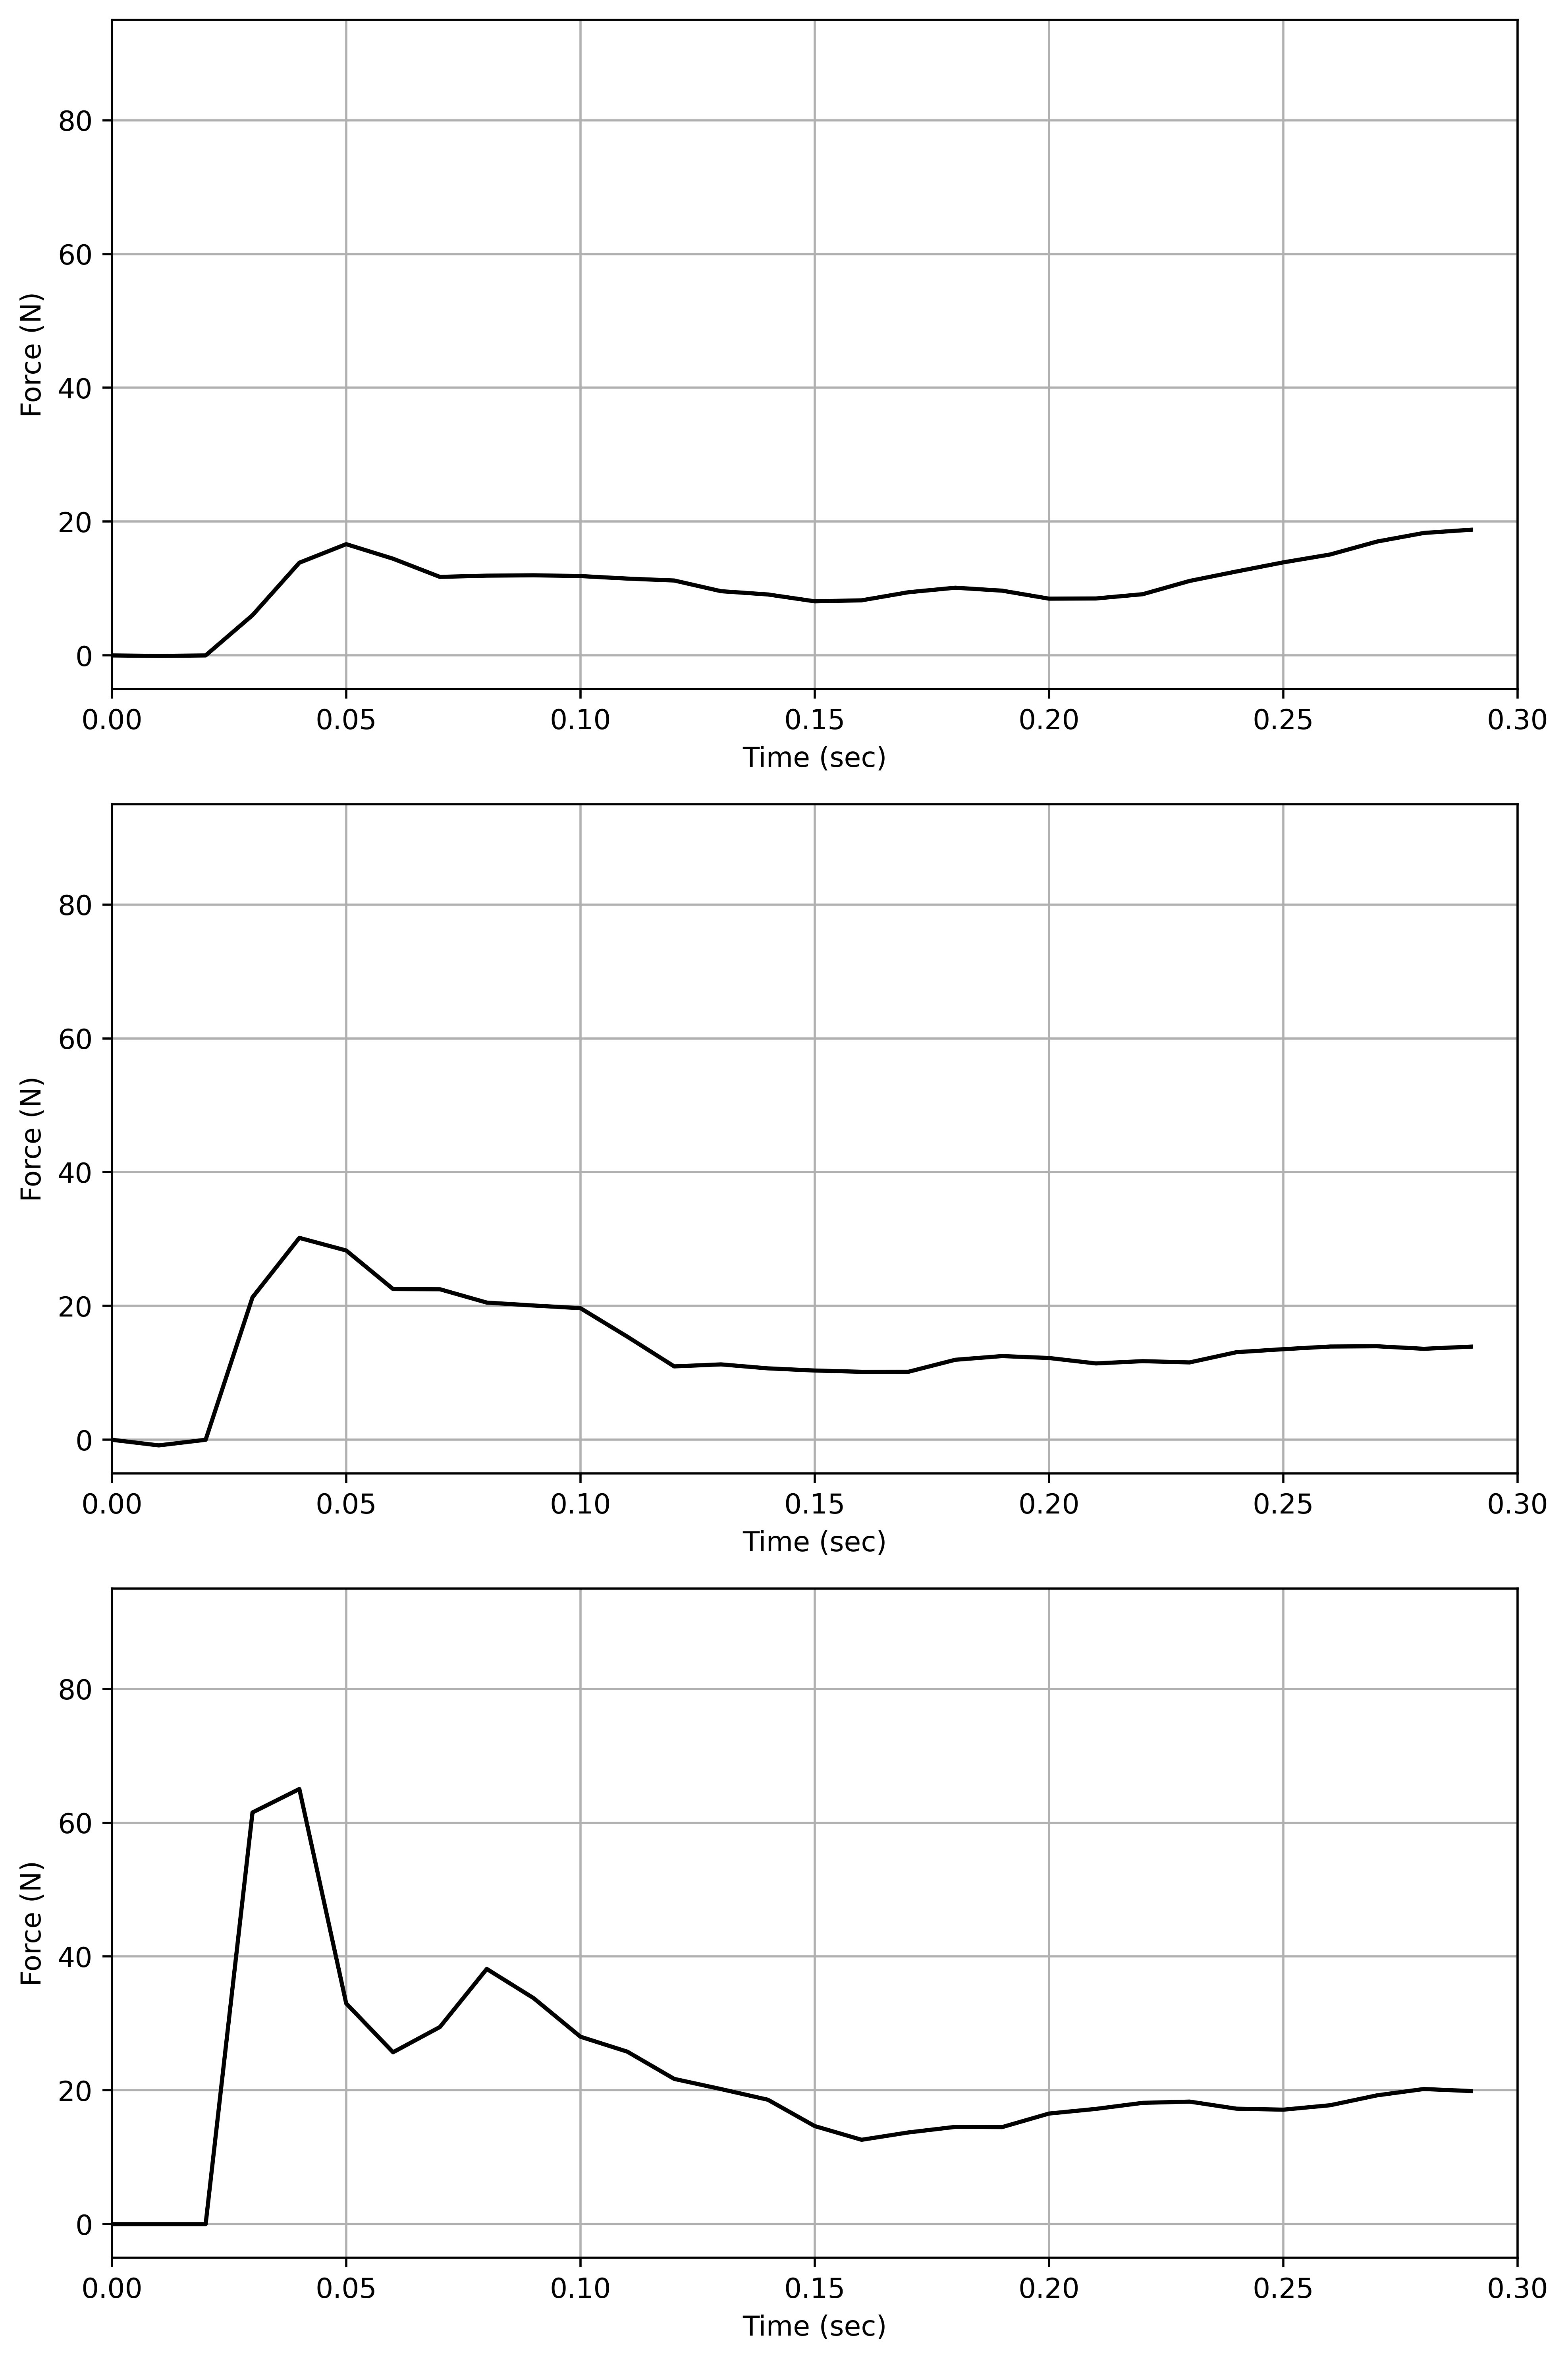

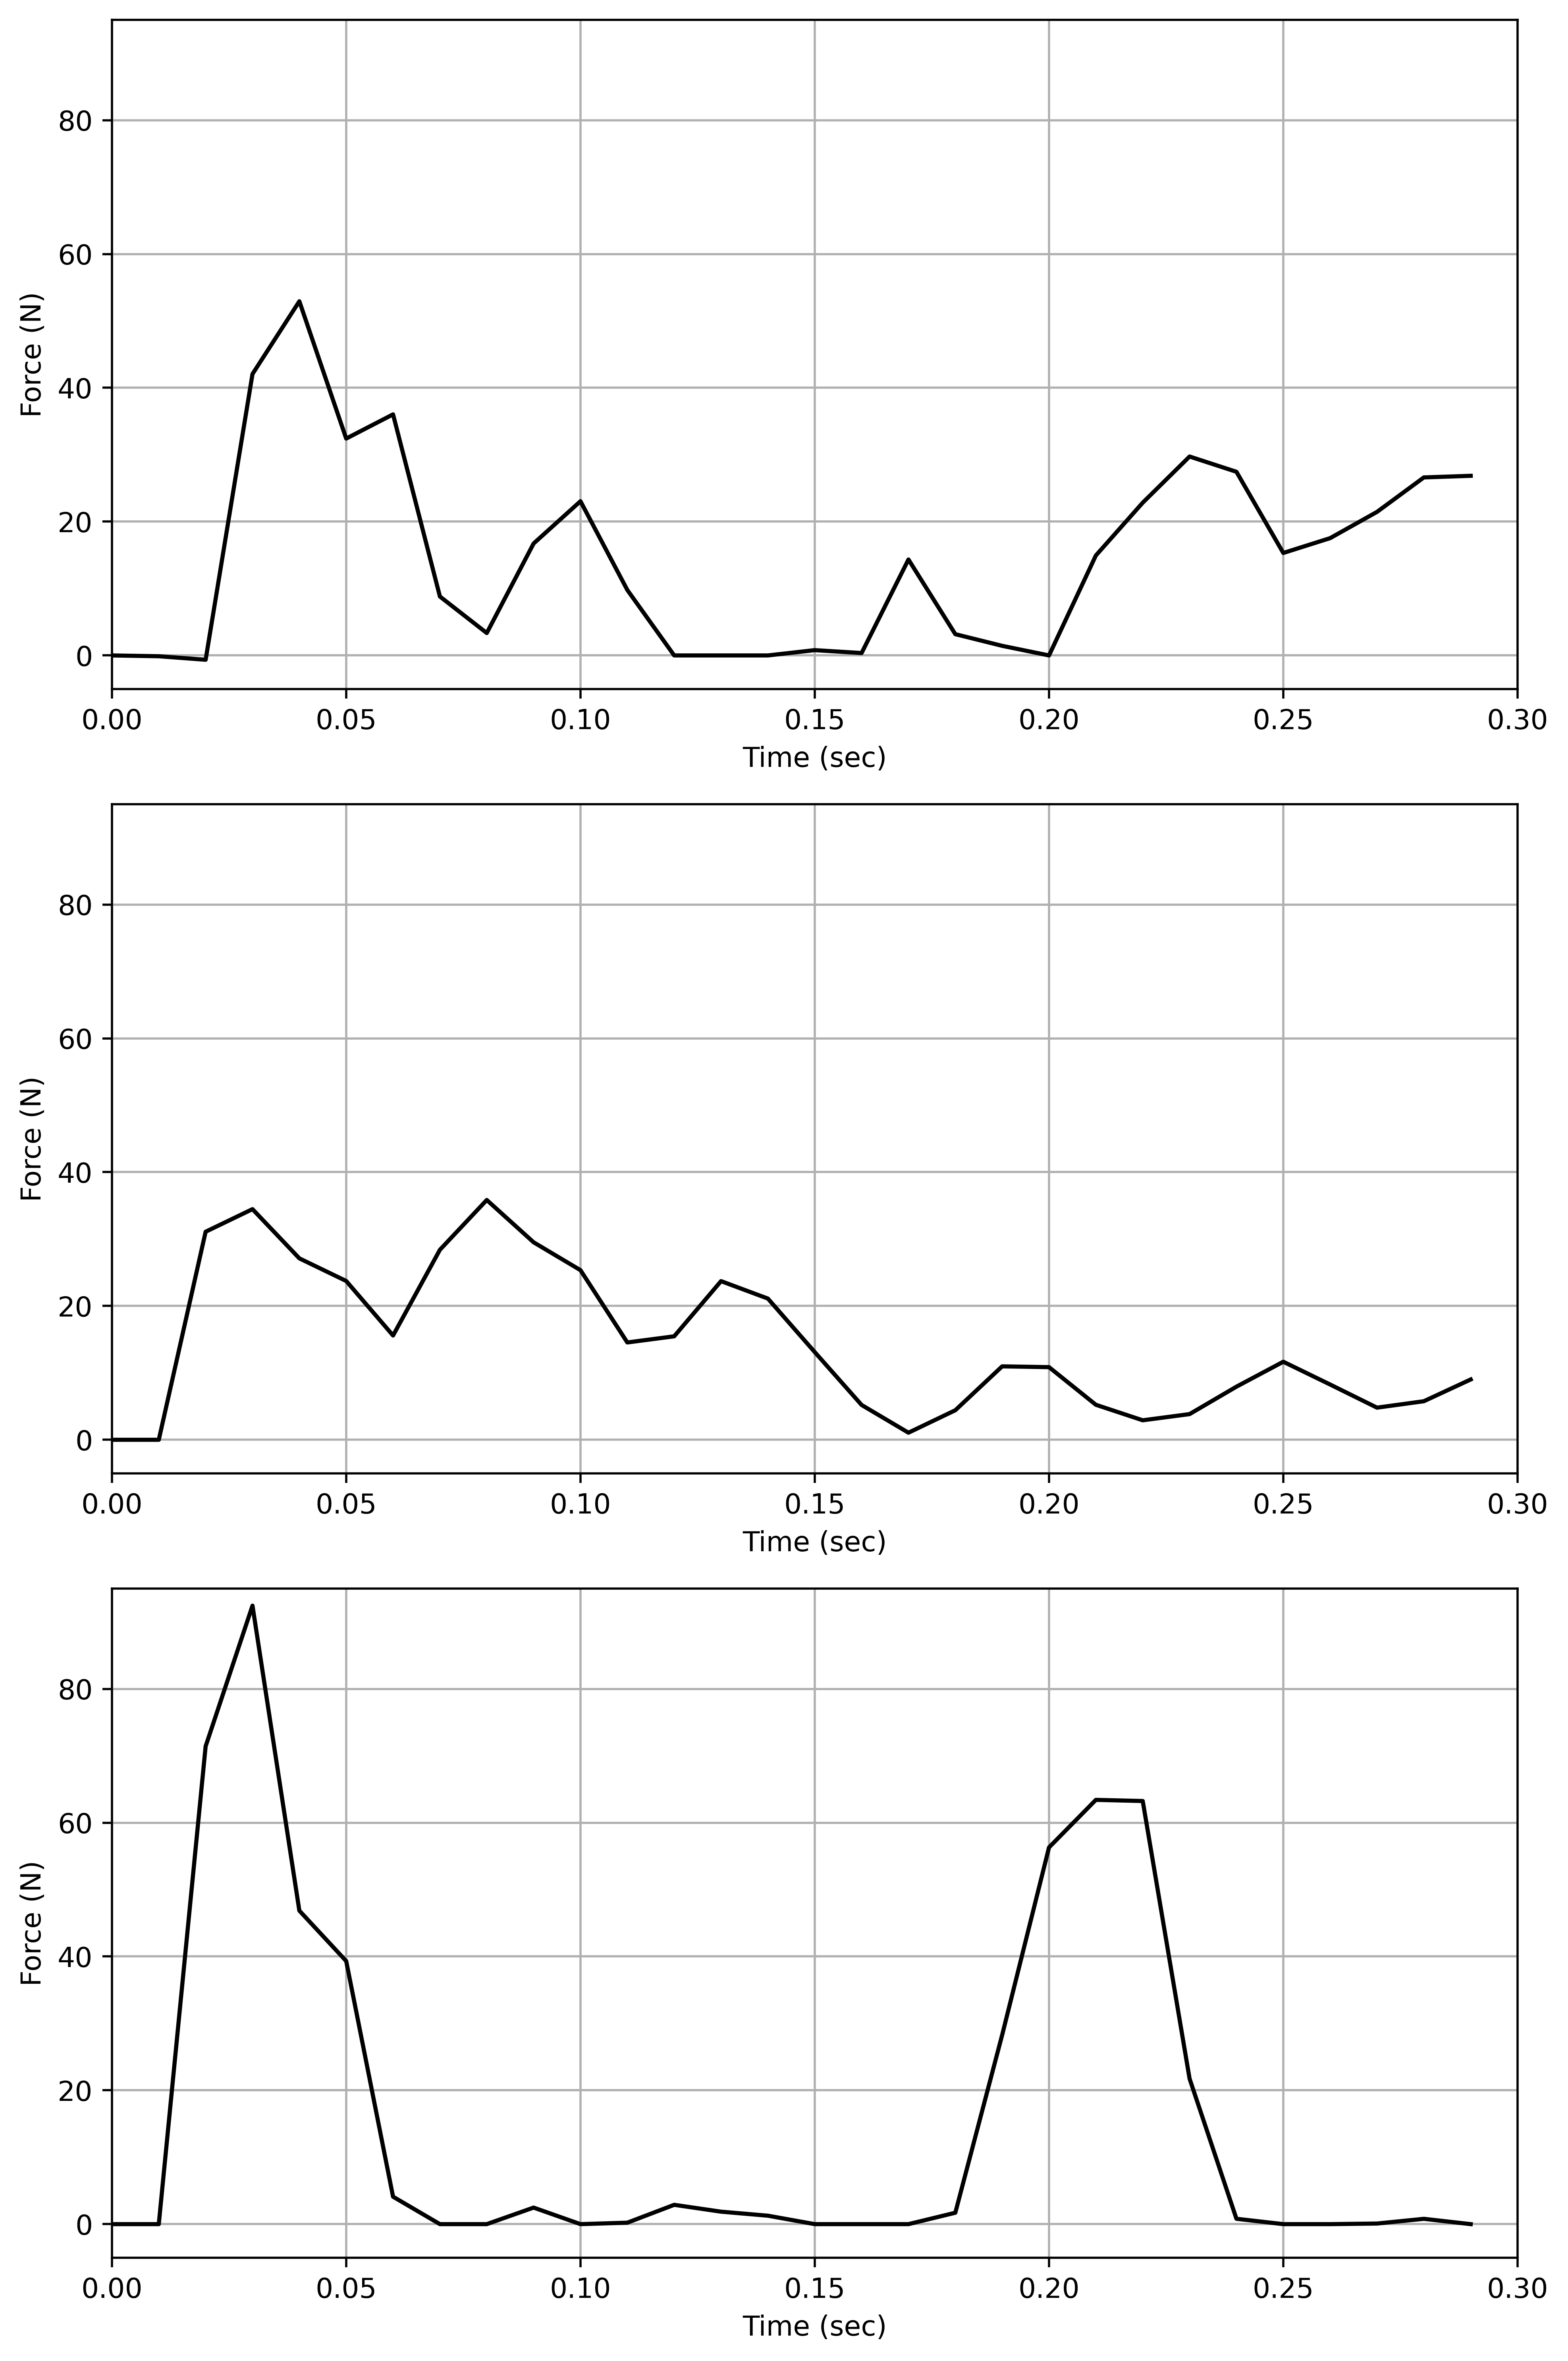

In [15]:
### Contact variance/stiffness

path = '../data/contact_var2/valid_18_07/'
list_of_baggies = [[ 'var_wd_cc_', 'var_low_', 'var_wd_'],  
           [  'hard_cc_', 'hard_wd_', 'hard_low_']]
datasets = ['Higher variance contact location (+/- 1cm)', 'Stiff (126 N/mm)']
namies = [ 'Well-damped', 'Chance constraint', 'Low impedance']

#fig, axs = plt.subplots(3, figsize=(8,8))
#fig.suptitle("Contact with GP-MPC")
for baggies, dataset in zip(list_of_baggies, datasets):
    fig, axs = plt.subplots(3, figsize=(8,12))
    cols = ['r', 'b', 'k' ]
    for subplot_idx, (bag, name) in enumerate(zip(baggies, namies)):
        col = 'k'
        forces = []
        damps = []
        imps = []
        i = 1
        state_msgs_orig = bag_loader(path+bag+str(i)+'.bag', map_robot_state, topic_name = 'robot_state')
        imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_impedance_gains, topic_name = 'impedance_gains')
        delta_imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_delta_impedance_gains, topic_name = 'delta_impedance_gains')
        state_msgs = get_aligned_msgs(imp_msgs, state_msgs_orig)
        delta_imp_msgs = get_aligned_msgs(imp_msgs, delta_imp_msgs)

        ind = 2
        start_ind = np.argmax(np.abs(state_msgs['force'][2,:])>5)-3
        #print("{} has st ind {}".format(bag+str(i), start_ind))
        plot_range = 30
        forces = state_msgs_orig['force'][ind,start_ind:start_ind+plot_range]
        times = [x / 100.0 for x in range(0, plot_range)]
        axs[subplot_idx].plot(times, forces, col)
        
    for i in range(3): 
        axs[i].grid(True)
        axs[i].set_xlim([0.0, 0.3])
        axs[i].set_ylim([-5, 95])
        axs[i].set_xlabel('Time (sec)')
        axs[i].set_ylabel('Force (N)')
    fig.tight_layout()
    fig.set_dpi(500)
plt.show()

Loading ros bag ../data/polish_flat2/validate_baseline1.bag  with 2834 msgs on topic /robot_state
Loading ros bag ../data/polish_flat2/validate_dist1.bag  with 2783 msgs on topic /robot_state


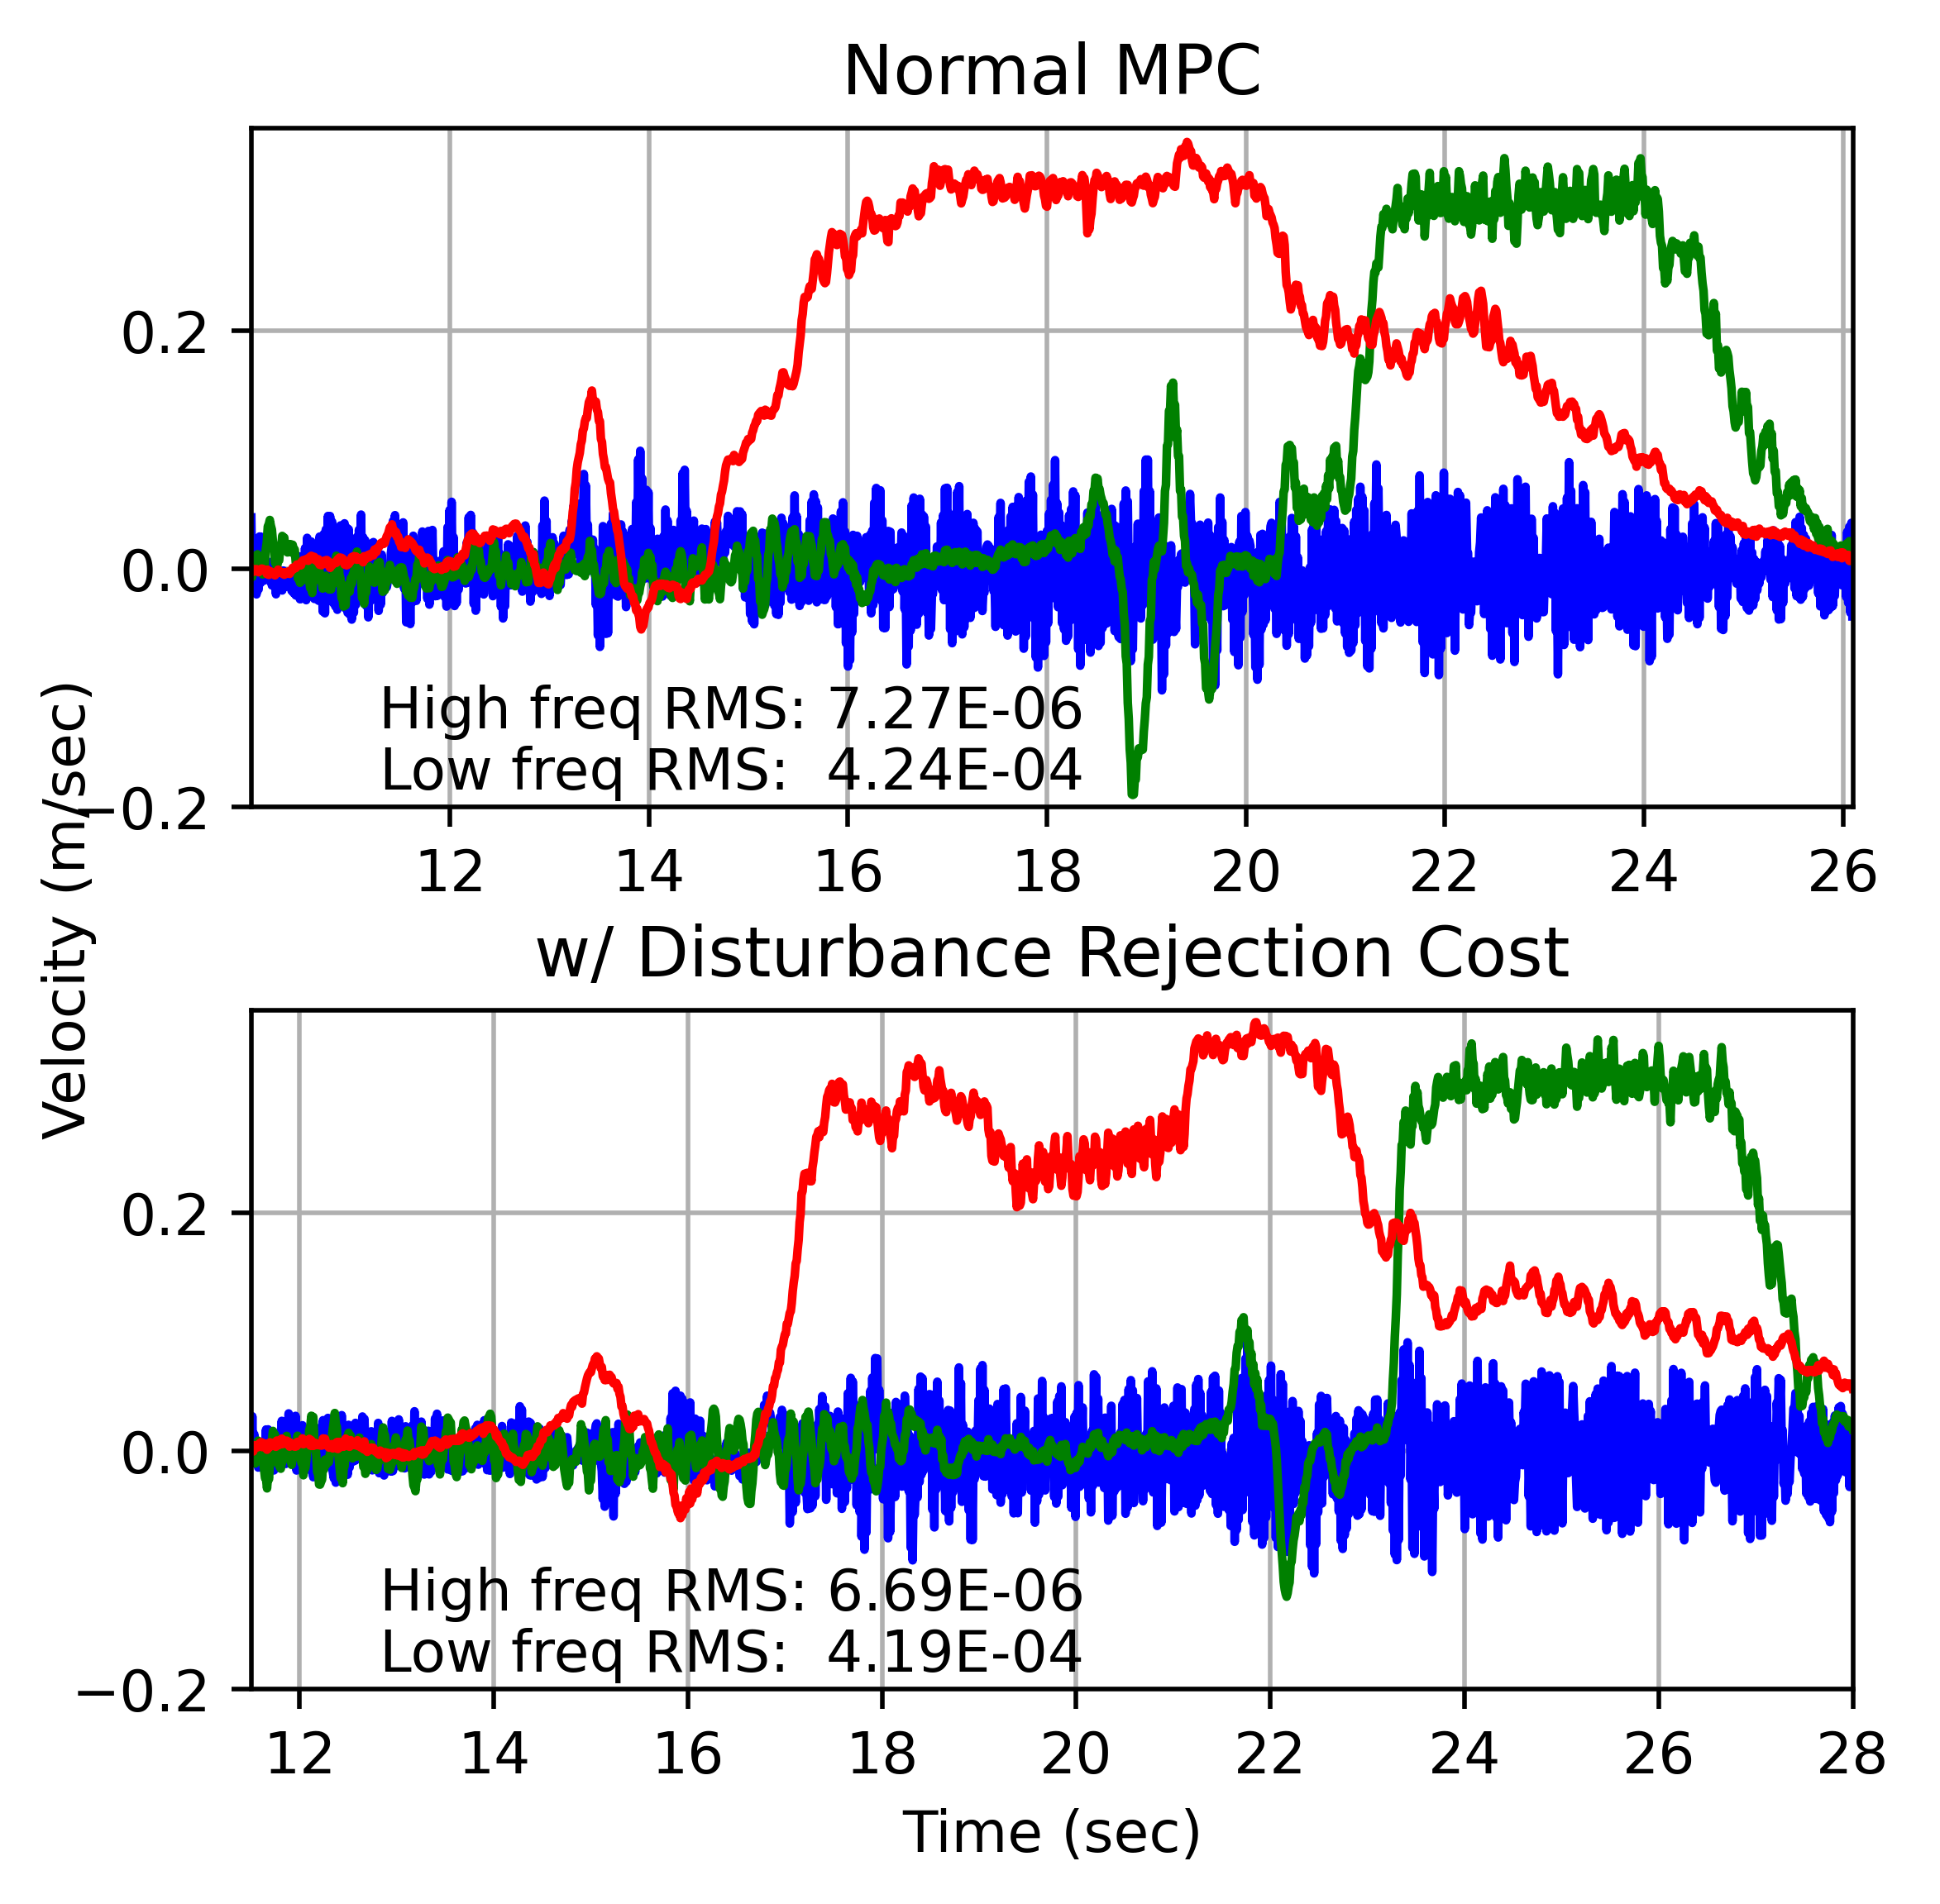

In [75]:
from scipy import signal

root = '../data/polish_flat2/'
baggies = ['validate_baseline1.bag', 'validate_dist1.bag']
namies = ['Normal MPC', 'w/ Disturbance Rejection Cost']
timeies = [[10, 26.1],
           [11.5, 28.0]]

cutoff = 15

def butter_highpass(cutoff, fs, typ, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype=typ, analog=False)
    return b, a

def butter_pass_filter(data, cutoff, fs, typ, order=5):
    b, a = butter_highpass(cutoff, fs, typ, order=order)
    y = signal.filtfilt(b, a, data)
    return y


fig, axs = plt.subplots(nrows = len(baggies), ncols = 1, figsize=(5,5))
for idx, (bag, name, times) in enumerate(zip(baggies, namies, timeies)):
    cols = ['r', 'g', 'b']
    dirs = ['X', 'Y', 'Z']
    msgs = bag_loader(root+bag, map_robot_state, topic_name = 'robot_state')
    low_freq_rms = 0
    high_freq_rms = 0
    
    for ind in (3,2,1):
        vel_lpf = butter_pass_filter(np.array(msgs['vel'][ind]),
                                         cutoff, 100, 'low')
        vel_hpf = butter_pass_filter(np.array(msgs['vel'][ind]),
                                         cutoff, 100, 'high')
        low_freq_rms += np.sum(vel_lpf**2)/len(vel_lpf)
        high_freq_rms += np.sum(vel_hpf**2)/len(vel_hpf)
                
        #st = 0 
        #en = len(msgs['t'])-1
        st = np.argmax(np.array(msgs['t'])>times[0])
        en = np.argmax(np.array(msgs['t'])>times[1])
        col = cols.pop()
        axs[idx].plot(msgs['t'][st:en], 10*np.array(msgs['vel'][ind,st:en]), col)
        axs[idx].set_xlim([msgs['t'][st], msgs['t'][en]])
    plt.text(0.3, 0.05, 'Low freq RMS:  {:.2E}'.format(low_freq_rms), 
             horizontalalignment='center', verticalalignment='center',
             transform = axs[idx].transAxes)
    plt.text(0.3, 0.14, 'High freq RMS: {:.2E}'.format(high_freq_rms),    
             horizontalalignment='center', verticalalignment='center',
             transform = axs[idx].transAxes)
    axs[idx].set_title(name)
    
#axs[0].legend()
for i in range(len(baggies)): axs[i].grid(True)
for i in range(len(baggies)): axs[i].set_ylim([-0.2, 0.37])

plt.xlabel('Time (sec)')
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('Velocity (m/sec)')
#plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
fig.set_dpi(500)
plt.show()

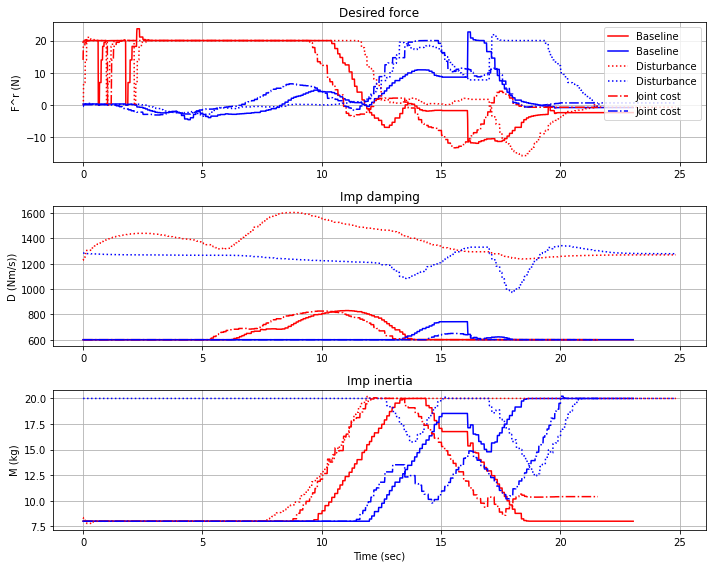

In [21]:
# Plotting the Impedance gains of the polishing task

# %matplotlib
path = '../data/polish_flat2/'
baggies = [ 'validate_baseline.bag',
            'validate_dist.bag',
            'validate_jt2.bag',
          ]  
namies = [ 'Baseline',
           'Disturbance',
           'Joint cost'
         ]
fig, axs = plt.subplots(3, figsize=(10,8))
#fig.suptitle("Contact with GP-MPC")
cols = ['r', 'b', 'r:', 'b:', 'r-.', 'b-.']
for bag, name in zip(baggies, namies):
    col = cols.pop(0)
    imp_msgs = bag_loader(path+bag, map_impedance_gains, topic_name = 'impedance_gains')
    #plt.figure(figsize=(6,3), dpi= 100)
    
    axs[0].plot(imp_msgs['t'], imp_msgs['Fd'][1], col, label = name)
    #axs[0].plot(imp_msgs['t'], delta_imp_msgs['Fd'][ind], col, label = name)
    axs[1].plot(imp_msgs['t'], imp_msgs['B'][1], col)
    axs[2].plot(imp_msgs['t'], imp_msgs['M'][1], col)
    
    col = cols.pop(0)
    axs[0].plot(imp_msgs['t'], imp_msgs['Fd'][2], col, label = name)
    #axs[0].plot(imp_msgs['t'], delta_imp_msgs['Fd'][ind], col, label = name)
    axs[1].plot(imp_msgs['t'], imp_msgs['B'][2], col)
    axs[2].plot(imp_msgs['t'], imp_msgs['M'][2], col)

axs[0].legend()
for i in range(3): axs[i].grid(True)
plt.xlabel('Time (sec)')
axs[0].set(ylabel='F^r (N)', title = 'Desired force')
axs[1].set(ylabel='D (Nm/s))', title = 'Imp damping')
axs[2].set(ylabel='M (kg)', title = 'Imp inertia')
plt.tight_layout()
plt.show()

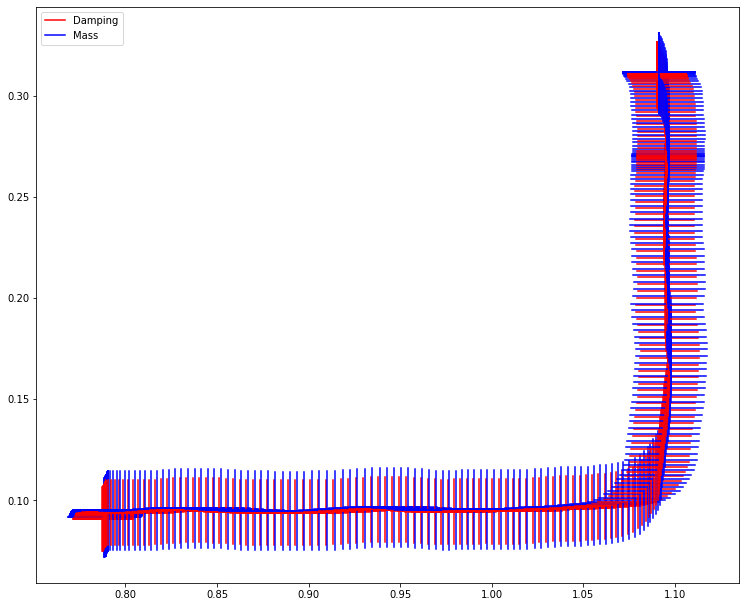